In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import json
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generic methods to convert json format to DataFrame

In [2]:
def compute_metrics(data : dict):
    oc_list = list()
    available_list = list()
    prev_available_list = list()
    deltabooked_list = list()
    correction_list = list()
    percentile_list = list()
    prev_percentile_list = list()
    config_list = list()
    prev_booked = 0
    prev_available = 0
    prev_percentile = 0
    for index in range(len(data["epoch"])):
        available = data["model"]["free_cpu"][index]
        config = data['node']["cpu_config"][index]
        ratio = (data['node']["booked_cpu"][index] + data["model"]["free_cpu"][index])/data['node']["cpu_config"][index]
        percentile = data['node']['cpu_percentile'][index]['99'] 
        delta_booked = data['node']["booked_cpu"][index] - prev_booked
        oc_list.append(ratio)
        available_list.append(available)
        prev_available_list.append(prev_available)
        deltabooked_list.append(delta_booked)
        if delta_booked>=0:
            correction_list.append(delta_booked)
        else:
            correction_list.append(percentile - prev_percentile)
        percentile_list.append(percentile)
        prev_percentile_list.append(prev_percentile)
        config_list.append(config)
        prev_available = available
        prev_percentile = percentile
        prev_booked = data['node']["booked_cpu"][index]
    return oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list

def add_line(dict_to_use : dict, curr_strategy, curr_iteration, oc_ratio, available, prev_available, delta_booked, correction, percentile, prev_percentile, config):
    dict_to_use["strategy"].append(curr_strategy)
    dict_to_use["iteration"].append(curr_iteration)
    dict_to_use["ratio"].append(oc_ratio)
    dict_to_use["available"].append(available)
    dict_to_use["prev_available"].append(prev_available)
    dict_to_use["delta_booked"].append(delta_booked)
    dict_to_use["correction"].append(correction)
    dict_to_use["percentile"].append(percentile)
    dict_to_use["prev_percentile"].append(prev_percentile)
    dict_to_use["config"].append(config)

def load_folder(folder : str):
    input_strat = dict()
    strategies = ['borg', 'doa', 'greedy', 'maxpeak', 'nsigma', 'percentile', 'rclike']
    #strategies = ['percentile']
    for strategy in strategies:
        input_strat[strategy] = folder + "/dump-" + strategy + ".json"
    
    compare_strat_dict = dict()
    compare_strat_dict["iteration"] = list()
    compare_strat_dict["strategy"] = list()
    compare_strat_dict["ratio"] = list()
    compare_strat_dict["available"] = list()
    compare_strat_dict["prev_available"] = list()
    compare_strat_dict["percentile"] = list()
    compare_strat_dict["delta_booked"] = list()
    compare_strat_dict["correction"] = list()
    compare_strat_dict["prev_percentile"] = list()
    compare_strat_dict["config"] = list()
    
    for strat, file in input_strat.items():
        print("Loading", strat, file)
        with open(file, 'r') as f:
            targeted_data = json.load(f)
        oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list = compute_metrics(targeted_data)
        for iteration_curr in range(len(oc_list)):
            add_line(compare_strat_dict, strat, iteration_curr, oc_list[iteration_curr], available_list[iteration_curr], prev_available_list[iteration_curr], deltabooked_list[iteration_curr], correction_list[iteration_curr], percentile_list[iteration_curr], prev_percentile_list[iteration_curr], config_list[iteration_curr])
    print("Done")
    
    return compare_strat_dict

# Load the "decreasing workload" trace

In [126]:
folder = "/usr/local/src/scroogevm/dump-decrease"

decreasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-decrease/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-decrease/dump-doa.json
Loading greedy /usr/local/src/scroogevm/dump-decrease/dump-greedy.json
Loading maxpeak /usr/local/src/scroogevm/dump-decrease/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-decrease/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-decrease/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-decrease/dump-rclike.json
Done


In [127]:
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] < 34]
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] > 0]

decreasing_df["prev_available_corrected"] = decreasing_df["prev_available"] - decreasing_df["correction"]
decreasing_df["available_groundthruth"] = decreasing_df["config"] - decreasing_df["percentile"]
decreasing_df["delta_available"] = decreasing_df["available"] - decreasing_df["prev_available_corrected"]

decreasing_df["current_available_misprediction"] = decreasing_df["available_groundthruth"] - decreasing_df["prev_available_corrected"]
decreasing_df["current_available_misprediction%"] = decreasing_df["current_available_misprediction"] / decreasing_df["config"]

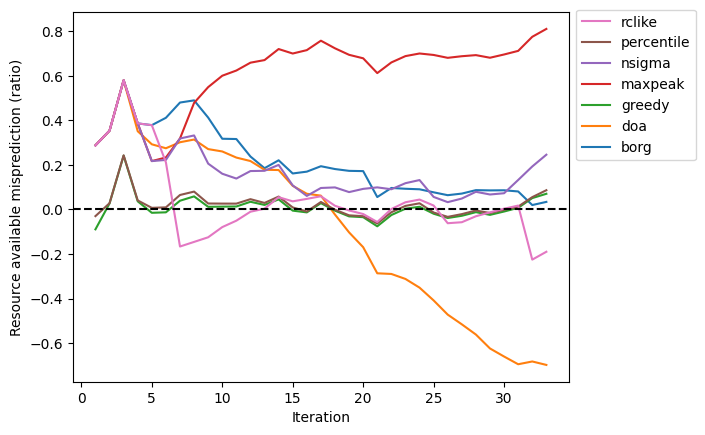

In [128]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=decreasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") #, palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Resource available misprediction (ratio)')

Strategy borg negative variation count: 9 total: -54.83803944128243 average: -6.093115493475826 max -17.51801396399481
Strategy doa negative variation count: 3 total: -13.204584944277528 average: -4.401528314759176 max -6.9180139639948095
Strategy greedy negative variation count: 16 total: -91.24490774935491 average: -5.702806734334682 max -13.318013963994801
Strategy maxpeak negative variation count: 18 total: -192.91859021907976 average: -10.717699456615541 max -40.897506542982406
Strategy nsigma negative variation count: 17 total: -116.02757079107553 average: -6.825151223004443 max -24.618013963994812
Strategy percentile negative variation count: 13 total: -81.7787537151683 average: -6.290673362705254 max -14.21801396399482
Strategy rclike negative variation count: 17 total: -113.86685908507255 average: -6.698050534416033 max -14.946039157690649


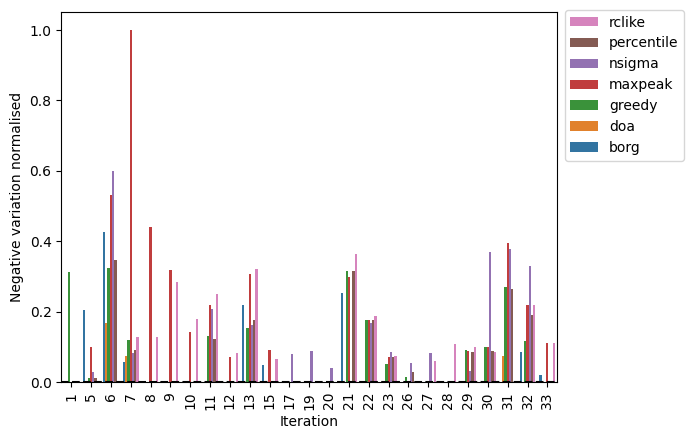

In [129]:
pd.options.mode.chained_assignment = None 
filter_df = decreasing_df.loc[decreasing_df['delta_available'] < 0]
min_val = filter_df['delta_available'].min()
max_val = filter_df['delta_available'].max()
filter_df['delta_available_norm'] = filter_df['delta_available'].apply(lambda x : (x - max_val) / (min_val - max_val))

sns.barplot(data=filter_df, x="iteration", y="delta_available_norm", hue="strategy")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Negative variation normalised')
x = plt.xticks(rotation=90)

strategies = decreasing_df['strategy'].unique()
for strategy in strategies:
    filter_strategy_df = filter_df.loc[filter_df['strategy'] ==  strategy]
    st_sum = filter_strategy_df['delta_available'].sum()
    st_mean = filter_strategy_df['delta_available'].mean()
    st_max = filter_strategy_df['delta_available'].min()
    
    print("Strategy", strategy, "negative variation count:", len(filter_strategy_df), "total:", st_sum, "average:", st_mean, "max", st_max)

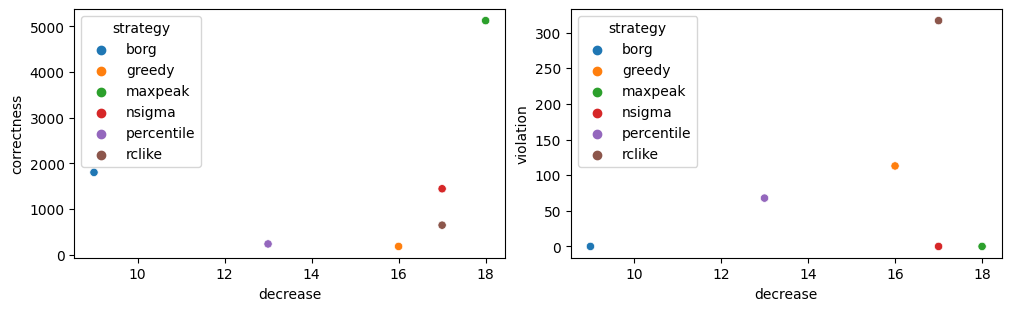

In [130]:
# Avg violation sur avg correction
decreasing_overall_res_dic= dict()
decreasing_overall_res_dic['strategy'] = list()
decreasing_overall_res_dic['violation'] = list()
decreasing_overall_res_dic['decrease'] = list()
decreasing_overall_res_dic['correctness'] = list()

for strategy in strategies:
    if strategy == 'doa': continue
        
    x = decreasing_df.loc[decreasing_df['strategy'] ==  strategy]
    
    xcorrectness = x.loc[x['current_available_misprediction'] >= 0]
    xviolat      = x.loc[x['current_available_misprediction'] < 0]
    xdecrease    = x.loc[x['delta_available'] < 0]
    
    decreasing_overall_res_dic['strategy'].append(strategy)
    
    decreasing_overall_res_dic['correctness'].append(xcorrectness['current_available_misprediction'].sum())
    decreasing_overall_res_dic['violation'].append(np.abs(xviolat['current_available_misprediction'].sum()))
    decreasing_overall_res_dic['decrease'].append(len(xdecrease))
    
decreasing_overall_res_df = pd.DataFrame(decreasing_overall_res_dic)

fig, axs = plt.subplots(1, 2, figsize=(10,3), layout='constrained')
x = sns.scatterplot(decreasing_overall_res_df, x='decrease', y='correctness', hue='strategy', ax=axs[0])
x = sns.scatterplot(decreasing_overall_res_df, x='decrease', y='violation', hue='strategy', ax=axs[1])

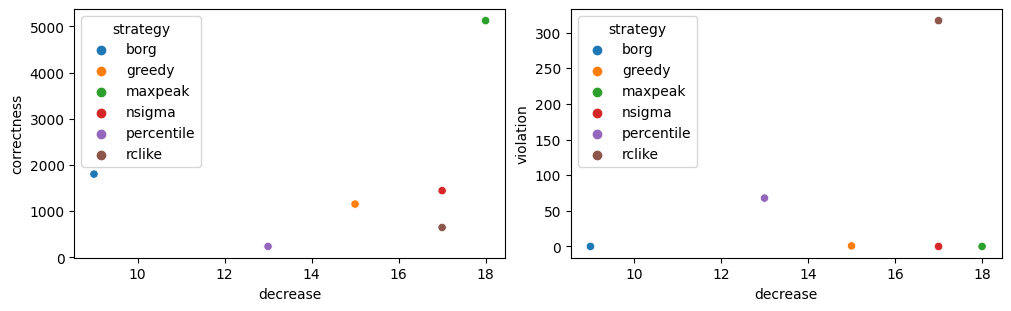

In [114]:
# Avg violation sur avg correction
decreasing_overall_res_dic= dict()
decreasing_overall_res_dic['strategy'] = list()
decreasing_overall_res_dic['violation'] = list()
decreasing_overall_res_dic['decrease'] = list()
decreasing_overall_res_dic['correctness'] = list()

for strategy in strategies:
    if strategy == 'doa': continue
        
    x = decreasing_df.loc[decreasing_df['strategy'] ==  strategy]
    
    xcorrectness = x.loc[x['current_available_misprediction'] >= 0]
    xviolat      = x.loc[x['current_available_misprediction'] < 0]
    xdecrease    = x.loc[x['delta_available'] < 0]
    
    decreasing_overall_res_dic['strategy'].append(strategy)
    
    decreasing_overall_res_dic['correctness'].append(xcorrectness['current_available_misprediction'].sum())
    decreasing_overall_res_dic['violation'].append(np.abs(xviolat['current_available_misprediction'].sum()))
    decreasing_overall_res_dic['decrease'].append(len(xdecrease))
    
decreasing_overall_res_df = pd.DataFrame(decreasing_overall_res_dic)

fig, axs = plt.subplots(1, 2, figsize=(10,3), layout='constrained')
x = sns.scatterplot(decreasing_overall_res_df, x='decrease', y='correctness', hue='strategy', ax=axs[0])
x = sns.scatterplot(decreasing_overall_res_df, x='decrease', y='violation', hue='strategy', ax=axs[1])

In [132]:
decreasing_overall_res_df.head()

,strategy,violation,decrease,correctness
0,borg,0.000000,9,1802.836886
1,greedy,112.929414,16,181.866300
2,maxpeak,0.000000,18,5126.236886
3,nsigma,0.000000,17,1444.836886
4,percentile,67.813175,13,236.350061


# Load the "increasing workload" trace

In [131]:
folder = "/usr/local/src/scroogevm/dump-increase"

increasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-increase/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-increase/dump-doa.json
Loading greedy /usr/local/src/scroogevm/dump-increase/dump-greedy.json
Loading maxpeak /usr/local/src/scroogevm/dump-increase/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-increase/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-increase/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-increase/dump-rclike.json
Done


In [99]:
increasing_df = increasing_df.loc[increasing_df["iteration"] < 34]
increasing_df = increasing_df.loc[increasing_df["iteration"] > 0]

increasing_df["prev_available_corrected"] = increasing_df["prev_available"] - increasing_df["correction"]
increasing_df["delta_available"] = increasing_df["available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available"] = increasing_df["config"] - increasing_df["percentile"]

increasing_df["current_available_misprediction"] = increasing_df["current_available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available_misprediction%"] = increasing_df["current_available_misprediction"] / increasing_df["config"]

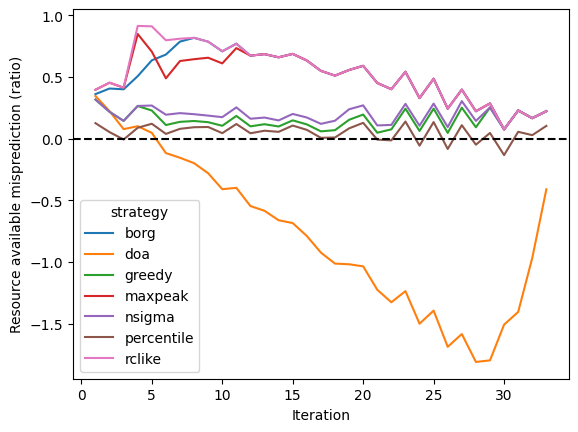

In [100]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=increasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") # , palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.ylabel('Resource available misprediction (ratio)')

Strategy borg negative variation count: 0 average: nan max nan
Strategy doa negative variation count: 4 average: -86.0 max -102.0
Strategy greedy negative variation count: 2 average: -6.350000000000004 max -9.800000000000002
Strategy maxpeak negative variation count: 2 average: -44.900000000000006 max -83.2
Strategy nsigma negative variation count: 2 average: -1.600000000000005 max -2.9000000000000057
Strategy percentile negative variation count: 1 average: -7.0 max -7.0
Strategy rclike negative variation count: 1 average: -100.0 max -100.0


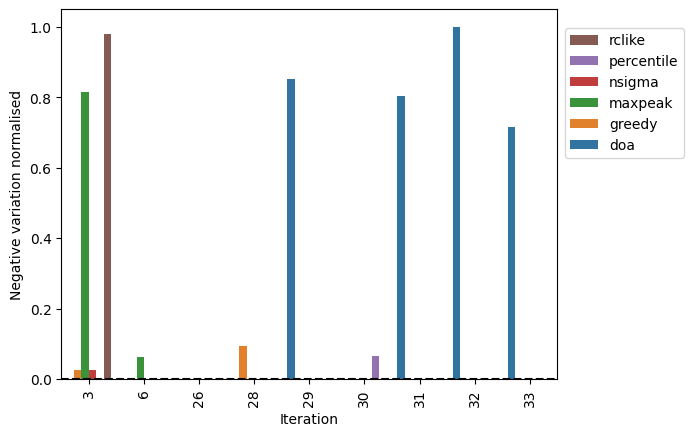

In [101]:
pd.options.mode.chained_assignment = None 
filter_df = increasing_df.loc[increasing_df['delta_available'] < 0]
min_val = filter_df['delta_available'].min()
max_val = filter_df['delta_available'].max()
filter_df['delta_available_norm'] = filter_df['delta_available'].apply(lambda x : (x - max_val) / (min_val - max_val))

sns.barplot(data=filter_df, x="iteration", y="delta_available_norm", hue="strategy")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Negative variation normalised')
x = plt.xticks(rotation=90)

strategies = increasing_df['strategy'].unique()
for strategy in strategies:
    filter_strategy_df = filter_df.loc[filter_df['strategy'] ==  strategy]
    st_mean = filter_strategy_df['delta_available'].mean()
    st_max = filter_strategy_df['delta_available'].min()
    print("Strategy", strategy, "negative variation count:", len(filter_strategy_df), "average:", st_mean, "max", st_max)

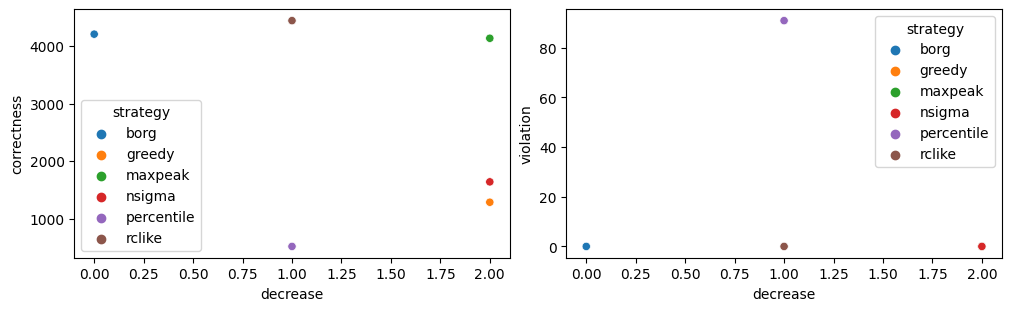

In [115]:
# Avg violation sur avg correction
increasing_overall_res_dic= dict()
increasing_overall_res_dic['strategy'] = list()
increasing_overall_res_dic['violation'] = list()
increasing_overall_res_dic['decrease'] = list()
increasing_overall_res_dic['correctness'] = list()
for strategy in strategies:
    if strategy == 'doa': continue
        
    x = increasing_df.loc[increasing_df['strategy'] ==  strategy]
    
    xcorrectness = x.loc[x['current_available_misprediction'] >= 0]
    xviolat      = x.loc[x['current_available_misprediction'] < 0]
    xdecrease    = x.loc[x['delta_available'] < 0]
    
    increasing_overall_res_dic['strategy'].append(strategy)
    
    increasing_overall_res_dic['correctness'].append(xcorrectness['current_available_misprediction'].sum())
    increasing_overall_res_dic['violation'].append(np.abs(xviolat['current_available_misprediction'].sum()))
    increasing_overall_res_dic['decrease'].append(len(xdecrease))
    
    np.abs(xdecrease['current_available_misprediction'].sum())

increasing_overall_res_df = pd.DataFrame(increasing_overall_res_dic)

fig, axs = plt.subplots(1, 2, figsize=(10,3), layout='constrained')
x = sns.scatterplot(increasing_overall_res_df, x='decrease', y='correctness', hue='strategy', ax=axs[0])
x = sns.scatterplot(increasing_overall_res_df, x='decrease', y='violation', hue='strategy', ax=axs[1])
#x.set_yscale('log')

# Compare both traces on the same board (Paper figure)

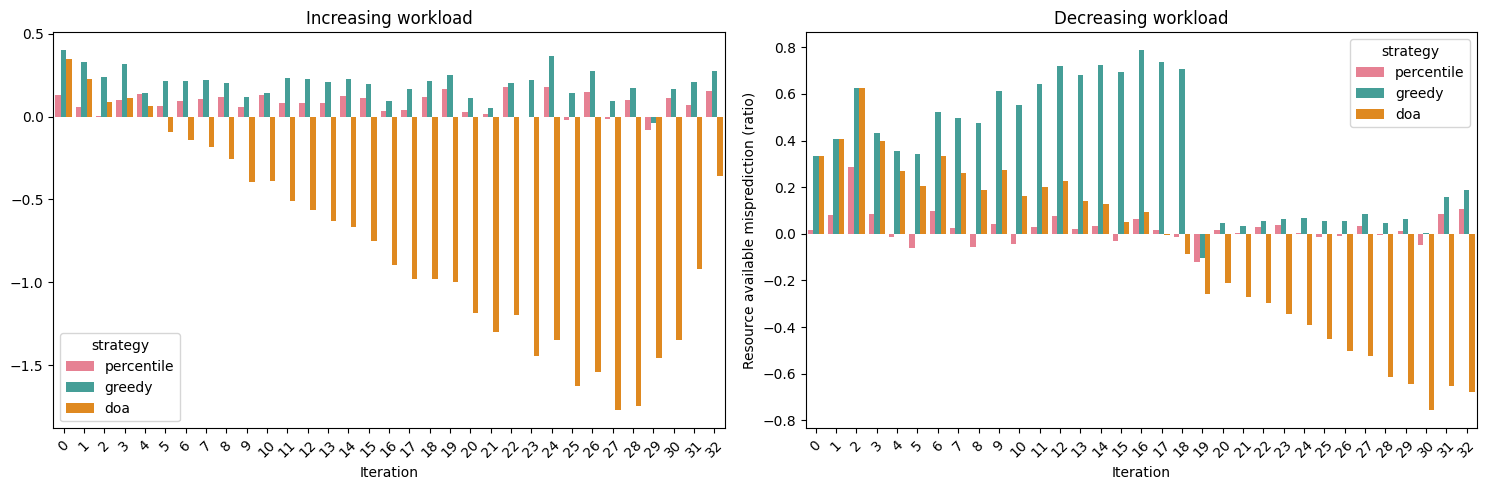

In [46]:
hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))


g = sns.barplot(data=compare_df2, x="iteration", y="current_available_misprediction%", hue="strategy",  palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax1)
ax1.set_title("Increasing workload")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("")
x = ax1.set_xticklabels(ax1.get_xticks(), rotation=45)

g = sns.barplot(data=compare_df, x="iteration", y="current_available_misprediction%", hue="strategy", palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax2)
ax2.set_title("Decreasing workload")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Resource available misprediction (ratio)")
x = ax2.set_xticklabels(ax2.get_xticks(), rotation=45)

fig.tight_layout()